In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report)

In [3]:
# Function to clean text
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    return text

# Load test dataset (Amazon Reviews)
amazon_df = pd.read_csv('/content/drive/MyDrive/ml-project/dataset/test.csv')
amazon_df['cleaned_review'] = amazon_df['review_text'].apply(clean_text)
amazon_df['sentiment'] = amazon_df['class_index'].apply(lambda x: 1 if x == 2 else 0)

# TF-IDF Vectorization
# tfidf = TfidfVectorizer(max_features=3000)
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
tfidf = TfidfVectorizer(max_features=5000, stop_words=list(ENGLISH_STOP_WORDS))

X_train = tfidf.fit_transform(amazon_df['cleaned_review'])
y_train = amazon_df['sentiment']

In [4]:
# feature_names = np.array(tfidf.get_feature_names_out())
# X_df = pd.DataFrame(X_train.toarray(), columns=feature_names)

# # Compute correlation between features and sentiment
# correlations = X_df.corrwith(amazon_df['sentiment']).abs().sort_values(ascending=False)

# # Select top correlated words
# top_n = 20
# top_features = correlations.head(top_n)

# # Plot bar chart of top words contributing to sentiment
# plt.figure(figsize=(12, 6))
# top_features.plot(kind='bar', color='skyblue')
# plt.title("Top TF-IDF Features Contributing to Sentiment")
# plt.xlabel("Words")
# plt.ylabel("Correlation with Sentiment")
# plt.xticks(rotation=45)
# plt.grid(axis='y', linestyle='--', alpha=0.5)
# plt.show()

In [5]:
df = pd.read_csv('/content/drive/MyDrive/ml-project/dataset/IMDB Dataset.csv')
df['cleaned_review'] = df['review'].apply(clean_text)
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

X_test = tfidf.fit_transform(df['cleaned_review'])
y_test = df['sentiment']

In [6]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Naive Bayes': MultinomialNB(),
    # 'SVM': SVC(kernel='linear', probability=True, random_state=42),
    # 'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

In [7]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_test, y_pred, model_name):
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.savefig(f'/content/drive/MyDrive/ml-project/results/confusion_matrix_{model_name}2.png')
    plt.show()


Training Logistic Regression...
[0 1 1 ... 0 1 1]
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.54      0.51      0.52     25000
           1       0.53      0.56      0.55     25000

    accuracy                           0.54     50000
   macro avg       0.54      0.54      0.53     50000
weighted avg       0.54      0.54      0.53     50000



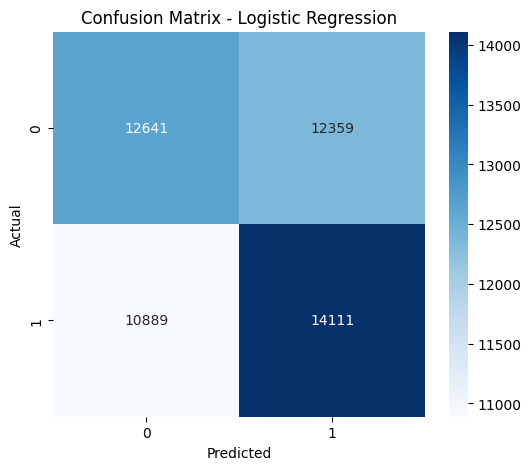


Training Naive Bayes...
[0 1 1 ... 0 0 1]
Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.56      0.51      0.53     25000
           1       0.55      0.61      0.58     25000

    accuracy                           0.56     50000
   macro avg       0.56      0.56      0.56     50000
weighted avg       0.56      0.56      0.56     50000



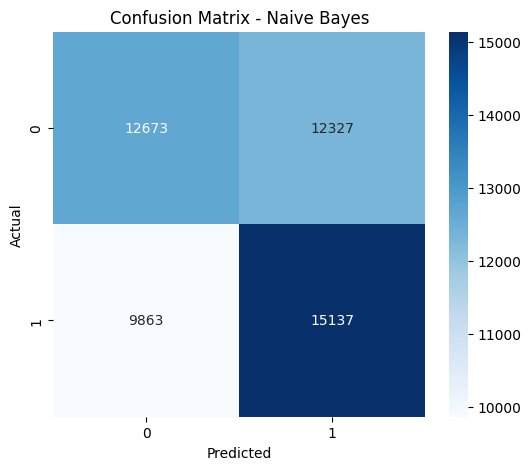

In [8]:
# Train models and generate plots
for name, model in models.items():
    print(f'\nTraining {name}...')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(y_pred)

    # Print Classification Report
    print(f'Classification Report for {name}:' )
    print(classification_report(y_test, y_pred))

    # Plot Confusion Matrix
    plot_confusion_matrix(y_test, y_pred, name)

In [9]:
# Function to plot ROC Curve
def plot_roc_curve(models, X_test, y_test):
    plt.figure(figsize=(8, 6))
    for name, model in models.items():
        y_probs = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc(fpr, tpr):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Baseline
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend()
    plt.savefig('/content/drive/MyDrive/ml-project/results/roc_curve2.png')
    plt.show()

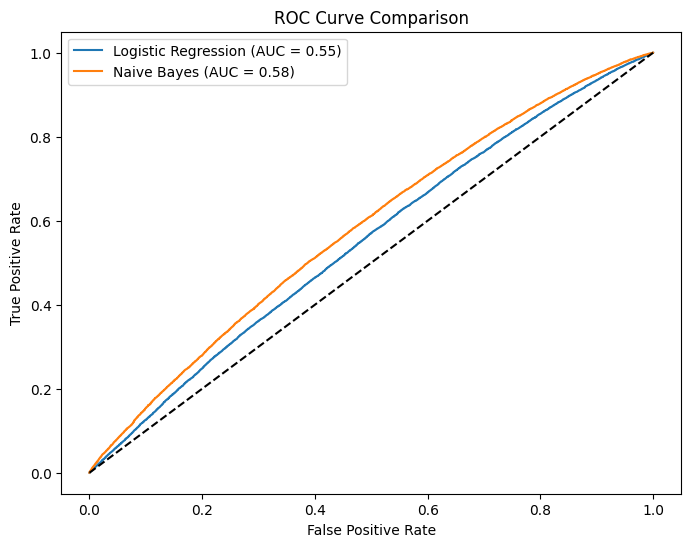

In [10]:
plot_roc_curve(models, X_test, y_test)

In [11]:
# Function to plot Precision-Recall Curve
def plot_precision_recall_curve(models, X_test, y_test):
    plt.figure(figsize=(8, 6))
    for name, model in models.items():
        y_probs = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_probs)
        plt.plot(recall, precision, label=f'{name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.savefig('/content/drive/MyDrive/ml-project/results/precision_recall_curve2.png')
    plt.show()

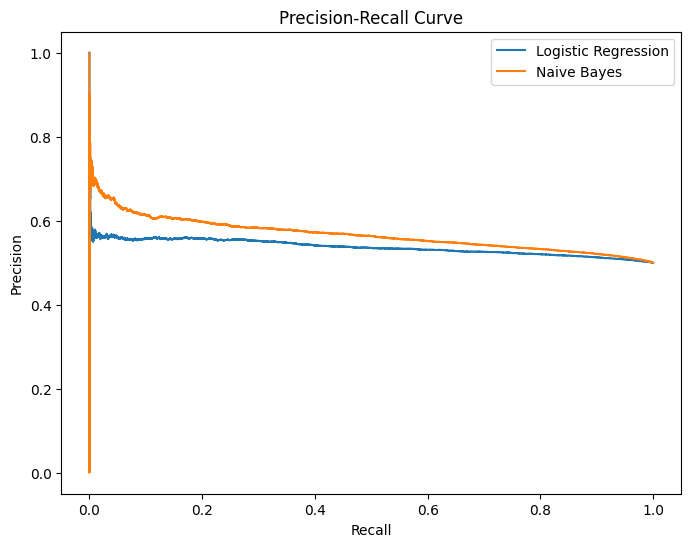

In [12]:
plot_precision_recall_curve(models, X_test, y_test)


In [13]:
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

def plot_feature_importance_across_models(models, tfidf, top_n=20):
    feature_names = np.array(tfidf.get_feature_names_out())  # Get feature names
    importance_dict = {}

    for model_name, model in models.items():
        if isinstance(model, LogisticRegression):  # Logistic Regression feature importance
            importance = model.coef_[0]
        elif isinstance(model, MultinomialNB):  # Naive Bayes uses log probabilities
            importance = model.feature_log_prob_[1] - model.feature_log_prob_[0]
        else:
            continue  # Skip models without feature importance

        importance_dict[model_name] = importance

    # Convert to DataFrame for easier manipulation
    importance_df = pd.DataFrame(importance_dict, index=feature_names)

    # Normalize feature importance (scale between 0 and 1)
    scaler = MinMaxScaler()
    importance_df = pd.DataFrame(scaler.fit_transform(importance_df),
                                 columns=importance_df.columns,
                                 index=importance_df.index)

    # Select top N words based on average importance
    top_features = importance_df.mean(axis=1).nlargest(top_n).index
    top_df = importance_df.loc[top_features]

    # Plot
    plt.figure(figsize=(12, 6))
    top_df.plot(kind="barh", figsize=(12, 6), cmap="viridis", alpha=0.75)
    plt.title(f"Top {top_n} Most Important Words Across Models")
    plt.xlabel("Normalized Feature Importance")
    plt.ylabel("Words")
    plt.legend(title="Model")
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.show()

# Function to plot feature importance (for Logistic Regression)
# def plot_feature_importance(model, tfidf):
#     feature_names = tfidf.get_feature_names_out()
#     importance = model.coef_[0]
#     top_features = np.argsort(importance)[-20:]
#     print(np.argsort(importance)[-100:])
#     plt.figure(figsize=(10, 5))
#     sns.barplot(x=importance[top_features], y=[feature_names[i] for i in top_features])
#     plt.title('Top 20 Most Important Words')
#     plt.xlabel('Coefficient Value')
#     plt.savefig('/content/drive/MyDrive/ml-project/results/feature_importance.png')
#     plt.show()

<Figure size 1200x600 with 0 Axes>

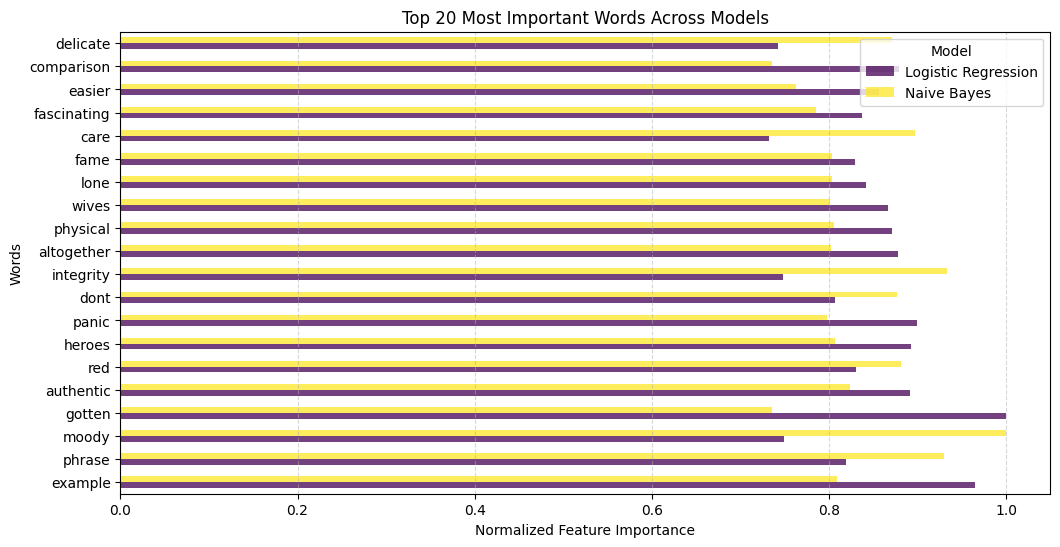

In [14]:
plot_feature_importance_across_models(models, tfidf, top_n=20)
